In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr
import networkx as nx


In [5]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [6]:
iso_calendar_dep = df_departures['date'].dt.isocalendar()
df_departures['week'] = iso_calendar_dep['year'].astype(str) + '-W' + iso_calendar_dep['week'].astype(str).str.zfill(2)

df_dep_by_airport = df_departures.groupby(['week']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_dep_by_airport.columns = ['week',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

iso_calendar_arr = df_arrivals['date'].dt.isocalendar()
df_arrivals['week'] = iso_calendar_arr['year'].astype(str) + '-W' + iso_calendar_arr['week'].astype(str).str.zfill(2)

df_arr_by_airport = df_arrivals.groupby(['week']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()


df_arr_by_airport.columns = ['week',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_all_by_airport = pd.merge(df_dep_by_airport, df_arr_by_airport, on=['week'], suffixes=('_dep', '_arr'))



print(df_all_by_airport.head())

print(df_all_by_airport.shape)

       week  deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0  2018-W12         2093.130804           1552.265659        2029.447664   
1  2018-W13         2128.403760           1669.489300        2051.815201   
2  2018-W14         2122.385703           1680.998196        1943.894175   
3  2018-W15         2039.815096           1575.742780        1944.876984   
4  2018-W16         2058.295976           1626.252646        1866.627873   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2246.019631       -1.631698         -1.233333       7.596806   
1        2379.220145       -1.513188         -1.233333       7.174415   
2        2340.201508       -1.833186         -1.500000       7.435481   
3        2204.102816       -1.200470         -1.066667       7.177975   
4        2272.727761       -1.393016         -1.133333       6.927848   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0       7.554167       

In [7]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

week                0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

week                0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

week                    0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


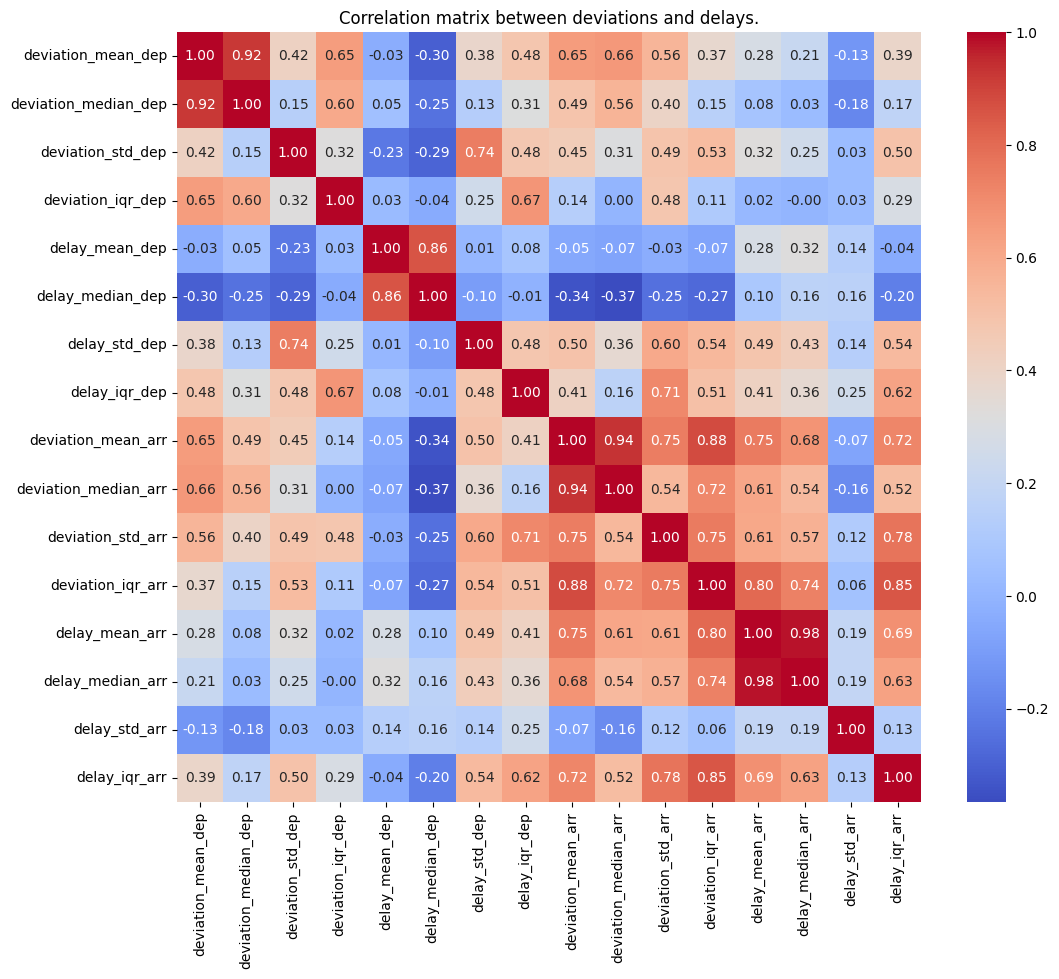

In [8]:
df_numeric = df_all_by_airport.drop(columns=['week'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [9]:
X_dep = df_dep_by_airport.drop(columns=['week']).dropna()

print(X_dep.head())
print()

scaler = StandardScaler()
X_scaled_dep = scaler.fit_transform(X_dep)

df_spanish_airports = pd.read_pickle('../../spanish_airports.pkl')

custom_tooltips_dep = np.array([
    f"{row['week']}" for _, row in df_dep_by_airport.iterrows()
])


print(X_scaled_dep)

   deviation_mean  deviation_median  deviation_std  deviation_iqr  delay_mean  \
0     2093.130804       1552.265659    2029.447664    2246.019631   -1.631698   
1     2128.403760       1669.489300    2051.815201    2379.220145   -1.513188   
2     2122.385703       1680.998196    1943.894175    2340.201508   -1.833186   
3     2039.815096       1575.742780    1944.876984    2204.102816   -1.200470   
4     2058.295976       1626.252646    1866.627873    2272.727761   -1.393016   

   delay_median  delay_std  delay_iqr  
0     -1.233333   7.596806   7.554167  
1     -1.233333   7.174415   7.850000  
2     -1.500000   7.435481   7.716667  
3     -1.066667   7.177975   7.616667  
4     -1.133333   6.927848   7.283333  

[[-2.74715509e-01 -1.62442890e+00  1.25503610e+00 -2.92468025e-01
  -1.14606376e+00 -2.52808626e-01  1.50909673e+00  5.86402214e-01]
 [ 3.28307758e-01  7.33903016e-02  1.51223247e+00  2.00034077e+00
  -3.61453685e-01 -2.52808626e-01  9.58204157e-02  2.09866763e+00]
 [ 2.2

In [10]:
X_arr = df_arr_by_airport.drop(columns=['week']).dropna()

print(X_arr.head())
print()

scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(X_arr)

custom_tooltips_arr = np.array([
     f"{row['week']}" for _, row in df_arr_by_airport.iterrows()
])

print(X_scaled_arr)


   deviation_mean  deviation_median  deviation_std  deviation_iqr  delay_mean  \
0     1801.134645       1334.927668    1668.991551    1964.036727   -0.009058   
1     1771.182168       1273.770353    1785.465384    1893.230777   -0.680118   
2     1889.747077       1365.000309    2016.159729    2025.779375   -0.069437   
3     1889.414545       1358.504339    1826.154178    2089.593558    0.492469   
4     1785.348106       1307.800873    1689.879683    1930.510912   -0.179506   

   delay_median  delay_std  delay_iqr  
0     -0.116667   6.268245   7.233333  
1     -0.650000   6.653880   7.166667  
2     -0.050000   7.157574   7.283333  
3      0.300000   6.766569   7.283333  
4     -0.083333   6.508002   7.050000  

[[-0.11939621 -0.2455289  -0.53049853  0.90273496  0.56192025  0.36023706
  -0.6495817   1.25607289]
 [-0.42761772 -1.07575562  0.48935672  0.3069202  -1.09765604 -1.33968345
  -0.2664047   0.97276482]
 [ 0.79245686  0.16271517  2.50933695  1.42228426  0.41259853  0.57272

In [11]:
X_all = df_all_by_airport.drop(columns=['week']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
     f"{row['week']}" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         2093.130804           1552.265659        2029.447664   
1         2128.403760           1669.489300        2051.815201   
2         2122.385703           1680.998196        1943.894175   
3         2039.815096           1575.742780        1944.876984   
4         2058.295976           1626.252646        1866.627873   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2246.019631       -1.631698         -1.233333       7.596806   
1        2379.220145       -1.513188         -1.233333       7.174415   
2        2340.201508       -1.833186         -1.500000       7.435481   
3        2204.102816       -1.200470         -1.066667       7.177975   
4        2272.727761       -1.393016         -1.133333       6.927848   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0       7.554167         1801.134645           1334.927668        1668.991551   
1 

In [12]:
def graph_stats(graph):
    G = nx.Graph()

    for node_id, members in graph['nodes'].items():
        nombres_miembros = [custom_tooltips_all[i] for i in members]
        G.add_node(node_id, members=nombres_miembros)

    for edge in graph['links']:
        G.add_edge(edge[0], edge[1])

    num_nodos = G.number_of_nodes()
    num_enlaces = G.number_of_edges()
    densidad = nx.density(G)
    grados = dict(G.degree())
    grado_medio = sum(grados.values()) / num_nodos if num_nodos > 0 else 0
    grado_max = max(grados.values()) if grados else 0
    grado_min = min(grados.values()) if grados else 0
    num_componentes_conectados = nx.number_connected_components(G)
    diametro = nx.diameter(G) if nx.is_connected(G) else max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))
    coef_agrupamiento = nx.average_clustering(G)

    print("Número de nodos:", num_nodos)
    print("Número de enlaces:", num_enlaces)
    print("Densidad del grafo:", densidad)
    print("Grado medio de los nodos:", grado_medio)
    print("Grado máximo:", grado_max)
    print("Grado mínimo:", grado_min)
    print("Número de componentes conectados:", num_componentes_conectados)
    print("Diámetro del grafo:", diametro)
    print("Coeficiente medio de agrupamiento:", coef_agrupamiento)
    print()
    print("-" * 30)

    for node_id, data in G.nodes(data=True):
        if(data and data['members']):    
            members = data['members']
            cluster_size = len(members)
            print(f"Clúster: {node_id}")
            print(f" - Número de miembros: {cluster_size}")
            print(f" - Miembros: {[str(member) for member in members]}")
            print("-" * 30)

In [19]:

mapper = km.KeplerMapper()

pca = PCA(n_components=1)
filter_values_dep = pca.fit_transform(X_scaled_dep)

node_color_function_dep = filter_values_dep[:, 0]

graph_dep = mapper.map(filter_values_dep,
                    X_scaled_dep,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=7, perc_overlap=0.2)
)

color_values_dep = X_scaled_dep[:, :8]
color_function_name_dep = X_dep.columns[:8]

mapper.visualize(graph_dep, 
                 path_html="mapper_output_dep.html", 
                 custom_tooltips=custom_tooltips_dep,
                 color_values=color_values_dep,
                 color_function_name=color_function_name_dep,
                 node_color_function=["mean", "std"])

graph_stats(graph_dep)

Número de nodos: 6
Número de enlaces: 1
Densidad del grafo: 0.06666666666666667
Grado medio de los nodos: 0.3333333333333333
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 5
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0

------------------------------
Clúster: cube1_cluster0
 - Número de miembros: 6
 - Miembros: ['2018-W18', '2018-W24', '2018-W25', '2018-W26', '2018-W35', '2018-W39']
------------------------------
Clúster: cube2_cluster0
 - Número de miembros: 5
 - Miembros: ['2018-W16', '2018-W27', '2018-W34', '2018-W35', '2018-W39']
------------------------------
Clúster: cube3_cluster0
 - Número de miembros: 8
 - Miembros: ['2018-W28', '2018-W29', '2018-W30', '2018-W33', '2018-W36', '2018-W40', '2018-W42', '2018-W43']
------------------------------
Clúster: cube4_cluster0
 - Número de miembros: 4
 - Miembros: ['2018-W23', '2018-W37', '2018-W38', '2018-W43']
------------------------------


In [21]:
pca = PCA(n_components=1)
filter_values_arr = pca.fit_transform(X_scaled_arr)

graph_arr = mapper.map(filter_values_arr, 
                    X_scaled_arr,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=5, perc_overlap=0.2)
)

color_values_arr = X_scaled_arr[:, :8]
color_function_name_arr = X_arr.columns[:8]

mapper.visualize(graph_arr, 
                 path_html="mapper_output_arr.html", 
                 custom_tooltips=custom_tooltips_arr, 
                 color_values=color_values_arr,
                 color_function_name=color_function_name_arr,
                 node_color_function=["mean", "std"])

graph_stats(graph_arr)

Número de nodos: 7
Número de enlaces: 1
Densidad del grafo: 0.047619047619047616
Grado medio de los nodos: 0.2857142857142857
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 6
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0

------------------------------
Clúster: cube0_cluster0
 - Número de miembros: 8
 - Miembros: ['2018-W19', '2018-W20', '2018-W24', '2018-W25', '2018-W31', '2018-W34', '2018-W39', '2018-W40']
------------------------------
Clúster: cube1_cluster0
 - Número de miembros: 9
 - Miembros: ['2018-W13', '2018-W19', '2018-W20', '2018-W30', '2018-W33', '2018-W35', '2018-W38', '2018-W39', '2018-W40']
------------------------------
Clúster: cube2_cluster0
 - Número de miembros: 7
 - Miembros: ['2018-W12', '2018-W13', '2018-W16', '2018-W17', '2018-W29', '2018-W37', '2018-W43']
------------------------------
Clúster: cube3_cluster0
 - Número de miembros: 7
 - Miembros: ['2018-W12', '2018-W22', '2018-W26', '2018-W28', '2018-W32', '2018-W42', '2018-W4

In [29]:
pca = PCA(n_components=1)
# pca = PCA().fit(X_scaled_all)
# print(pca.explained_variance_ratio_)
filter_values_all = pca.fit_transform(X_scaled_all)


graph_all = mapper.map(filter_values_all, 
                    X_scaled_all,
                    clusterer=DBSCAN(eps=3.5, min_samples=3),
                    cover=km.Cover(n_cubes=7, perc_overlap=0.2)
)

color_values_all = X_scaled_all[:, :16]
color_function_name_all = X_all.columns[:16]

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all)

Número de nodos: 7
Número de enlaces: 1
Densidad del grafo: 0.047619047619047616
Grado medio de los nodos: 0.2857142857142857
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 6
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0

------------------------------
Clúster: cube0_cluster0
 - Número de miembros: 5
 - Miembros: ['2018-W20', '2018-W24', '2018-W25', '2018-W34', '2018-W39']
------------------------------
Clúster: cube1_cluster0
 - Número de miembros: 5
 - Miembros: ['2018-W19', '2018-W24', '2018-W35', '2018-W39', '2018-W40']
------------------------------
Clúster: cube2_cluster0
 - Número de miembros: 3
 - Miembros: ['2018-W33', '2018-W38', '2018-W40']
------------------------------
Clúster: cube3_cluster0
 - Número de miembros: 4
 - Miembros: ['2018-W12', '2018-W29', '2018-W37', '2018-W43']
------------------------------
Clúster: cube4_cluster0
 - Número de miembros: 8
 - Miembros: ['2018-W15', '2018-W22', '2018-W27', '2018-W28', '2018-W32', '2018-W36'